# Lab 10 - Task 2 Baseline

In this class, we will develop a baseline for Task 2 using a subset of the lego dataset. We will model the task as an ordinal classification task.

In [2]:
import matplotlib.pyplot as plt, numpy as np, os, torch, random, cv2
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision import transforms, models
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import pandas as pd


random.seed(42)

### Connect Colab to Drive (if the dataset is on drive)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip "drive/MyDrive/Legos/photos.zip"

## Load dataset

In the Lego dataset, the images are organized into folders according to the number of legos. In this notebook, we will only consider images with up to 4 legos.

In [29]:
images_directory = "photos"

# Obtain names of images for training and validation
image_paths = []
num_legos = []
for dirpath, dirnames, filenames in os.walk(images_directory):
    for filename in filenames:
        # Check how many legos the image has
        n = int(dirpath.split(os.sep)[-1])
        num_legos.append(n)
        if filename.endswith('.jpg'):
            image_paths.append(os.path.join(dirpath, filename))

image_paths = np.asarray(image_paths)

num_legos = torch.Tensor(num_legos).to(torch.int64)

# Use csv file to get the split
split_df = pd.read_csv("train_test_split.csv")
# Define the test has th paths that have column is_test = 1
split = np.zeros(len(image_paths))
for i, path in enumerate(image_paths):
    split[i] = int(split_df[split_df["filename"] == path]["is_test"].values[0])

test_indexes = np.where(split == 1)[0]
other_indexes =  np.where(split == 0)[0]

# Split the other indexes into train and validation
random.shuffle(other_indexes)
train_indexes = other_indexes[:int(0.8*len(other_indexes))]
valid_indexes = other_indexes[int(0.8*len(other_indexes)):]


# get number of legos for each class 1,2,3,4
num_legos_train = num_legos[train_indexes]
# Get the indexes where num_legos is 1
one_lego_indexes = np.where(num_legos_train == 1)[0]
random.shuffle(one_lego_indexes)
one_lego_indexes = one_lego_indexes[:50]
train_indexes = np.concatenate((train_indexes[np.where(num_legos_train != 1)[0]], train_indexes[one_lego_indexes]))

# Get the indexes where num_legos is 2
num_legos_train = num_legos[train_indexes]
two_lego_indexes = np.where(num_legos_train == 2)[0]
random.shuffle(two_lego_indexes)
two_lego_indexes = two_lego_indexes[:50]
train_indexes = np.concatenate((train_indexes[np.where(num_legos_train != 2)[0]], train_indexes[two_lego_indexes]))


# print label distribution for train
num_legos_train = num_legos[train_indexes]
print(f"Train label distribution: {torch.bincount(num_legos_train)}")



# print relative size of each
total = len(train_indexes) + len(valid_indexes) + len(test_indexes)
print(f"Train size: {len(train_indexes)/total}")
print(f"Validation size: {len(valid_indexes)/total}")
print(f"Test size: {len(test_indexes)/total}")


Train label distribution: tensor([ 0, 50, 50, 49, 27])
Train size: 0.4489795918367347
Validation size: 0.3647959183673469
Test size: 0.18622448979591838


In [8]:
class LegosDataset(Dataset):
    def __init__(self, images_filenames, num_legos, transform=None):
        self.images_filenames = images_filenames
        self.transform = transform

        # Transform number of legos into one hot encoding
        self.labels = num_legos - 1

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        label = self.labels[idx]

        # Read image
        image = cv2.imread(image_filename)

        # Convert from BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Apply the same data augmentation to both input image and target mask
        if self.transform is not None:
            image = self.transform(image)

        return image, label




In [9]:
batch_size = 32
num_workers = 2

# Define transformations to be applied to data
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(224),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
)

# Define datasets and dataloaders
train_dataset = LegosDataset(image_paths[train_indexes], num_legos[train_indexes], transform=transform)
valid_dataset = LegosDataset(image_paths[valid_indexes], num_legos[valid_indexes], transform=transform)
test_dataset = LegosDataset(image_paths[test_indexes], num_legos[test_indexes], transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)



## Defining the model

Load a pre-trained convolutional neural network of your own choice from torchvision. Do not forget to change the last layer to match the number of classes (4)!

In [14]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 4)

# Freeze all layers except the last one
for name, param in model.named_parameters():
    if "fc" not in name:
        param.requires_grad = False

model.to(device)


Using cpu device


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Train the model

Define function to perform one iteration

In [16]:
def step(model, dataloader, loss_fn, device, optimizer=None, is_train=True):
    if is_train:
        model.train()
    else:
        model.eval()

    running_loss = 0.0
    all_labels = []
    all_predictions = []

    for images, labels in tqdm(dataloader):
        images = images.to(device)
        labels = labels.to(device)

        if is_train:
            optimizer.zero_grad()

        with torch.set_grad_enabled(is_train):
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            if is_train:
                loss.backward()
                optimizer.step()

        running_loss += loss.item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(outputs.argmax(dim=1).detach().cpu().numpy())

    loss = running_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_predictions)

    return loss, accuracy



Define function to train a model

In [12]:
train_history = pd.DataFrame(columns=['loss', 'accuracy'])
val_history = pd.DataFrame(columns=['loss', 'accuracy'])
def train(model, train_dataloader, valid_dataloader, loss_fn, optimizer, device, num_epochs):
    train_losses = []
    valid_losses = []
    valid_accuracies = []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = step(model, train_dataloader, loss_fn, device, optimizer=optimizer, is_train=True)
        valid_loss, valid_accuracy = step(model, valid_dataloader, loss_fn, device, is_train=False)

        print(f"Epoch {epoch + 1}/{num_epochs}, train_loss: {train_loss:.4f}, train_accuracy: {train_accuracy:.4f}, valid_loss: {valid_loss:.4f}, valid_accuracy: {valid_accuracy:.4f}")
        train_history.loc[epoch] = [train_loss, train_accuracy]
        val_history.loc[epoch] = [valid_loss, valid_accuracy]
        

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)

    return train_losses, valid_losses, valid_accuracies

Define loss, optimizer and train the model. Remember that we will model this regression task problem as a classification problem when choosing the loss function!

In [18]:
# Define loss function
loss_fn = nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 20

# print the size of the data
print(f"Train size: {len(train_dataloader.dataset)}")

# Train the model
train_losses, valid_losses, valid_accuracies = train(model, train_dataloader, valid_dataloader, loss_fn, optimizer, device, num_epochs)

torch.save(model.state_dict(), "recent.pth")


100%|██████████| 5/5 [00:12<00:00,  2.46s/it]


Epoch 1/20, train_loss: 1.0597, train_accuracy: 0.5035, valid_loss: 1.2018, valid_accuracy: 0.4615


100%|██████████| 5/5 [00:15<00:00,  3.10s/it]


Epoch 2/20, train_loss: 1.0429, train_accuracy: 0.5211, valid_loss: 1.1911, valid_accuracy: 0.4615


100%|██████████| 5/5 [00:10<00:00,  2.14s/it]


Epoch 3/20, train_loss: 1.0277, train_accuracy: 0.5194, valid_loss: 1.1742, valid_accuracy: 0.4685


100%|██████████| 5/5 [00:11<00:00,  2.24s/it]


Epoch 4/20, train_loss: 1.0069, train_accuracy: 0.5651, valid_loss: 1.1644, valid_accuracy: 0.4825


100%|██████████| 5/5 [00:10<00:00,  2.03s/it]


Epoch 5/20, train_loss: 0.9898, train_accuracy: 0.5669, valid_loss: 1.1455, valid_accuracy: 0.4895


100%|██████████| 5/5 [00:11<00:00,  2.30s/it]


Epoch 6/20, train_loss: 0.9779, train_accuracy: 0.5792, valid_loss: 1.1432, valid_accuracy: 0.5105


100%|██████████| 5/5 [00:14<00:00,  2.97s/it]


Epoch 7/20, train_loss: 0.9644, train_accuracy: 0.5863, valid_loss: 1.1240, valid_accuracy: 0.5385


100%|██████████| 5/5 [00:22<00:00,  4.60s/it]


Epoch 8/20, train_loss: 0.9465, train_accuracy: 0.5810, valid_loss: 1.1211, valid_accuracy: 0.5315


100%|██████████| 5/5 [00:16<00:00,  3.30s/it]


Epoch 9/20, train_loss: 0.9359, train_accuracy: 0.6180, valid_loss: 1.1107, valid_accuracy: 0.5175


100%|██████████| 5/5 [00:13<00:00,  2.80s/it]


Epoch 10/20, train_loss: 0.9339, train_accuracy: 0.6109, valid_loss: 1.1047, valid_accuracy: 0.5245


100%|██████████| 5/5 [00:10<00:00,  2.13s/it]


Epoch 11/20, train_loss: 0.9149, train_accuracy: 0.6250, valid_loss: 1.0937, valid_accuracy: 0.5175


100%|██████████| 5/5 [00:09<00:00,  1.89s/it]


Epoch 12/20, train_loss: 0.9038, train_accuracy: 0.6356, valid_loss: 1.0850, valid_accuracy: 0.5385


100%|██████████| 5/5 [00:09<00:00,  1.85s/it]


Epoch 13/20, train_loss: 0.8901, train_accuracy: 0.6356, valid_loss: 1.0819, valid_accuracy: 0.5245


100%|██████████| 5/5 [00:09<00:00,  1.88s/it]


Epoch 14/20, train_loss: 0.8798, train_accuracy: 0.6356, valid_loss: 1.0623, valid_accuracy: 0.5385


100%|██████████| 5/5 [00:09<00:00,  1.98s/it]


Epoch 15/20, train_loss: 0.8860, train_accuracy: 0.6373, valid_loss: 1.0659, valid_accuracy: 0.5524


100%|██████████| 5/5 [00:09<00:00,  1.91s/it]


Epoch 16/20, train_loss: 0.8736, train_accuracy: 0.6514, valid_loss: 1.0583, valid_accuracy: 0.5455


100%|██████████| 5/5 [00:08<00:00,  1.79s/it]


Epoch 17/20, train_loss: 0.8635, train_accuracy: 0.6514, valid_loss: 1.0607, valid_accuracy: 0.5455


100%|██████████| 5/5 [00:09<00:00,  1.95s/it]


Epoch 18/20, train_loss: 0.8588, train_accuracy: 0.6391, valid_loss: 1.0479, valid_accuracy: 0.5524


100%|██████████| 5/5 [00:11<00:00,  2.37s/it]


Epoch 19/20, train_loss: 0.8399, train_accuracy: 0.6585, valid_loss: 1.0410, valid_accuracy: 0.5524


100%|██████████| 5/5 [00:11<00:00,  2.27s/it]

Epoch 20/20, train_loss: 0.8439, train_accuracy: 0.6655, valid_loss: 1.0446, valid_accuracy: 0.5664


In [ ]:
# load the model
model.load_state_dict(torch.load("recent.pth"))


# Unfreeze all layers
for param in model.parameters():
    param.requires_grad = True

num_epochs = 50

# Train the model
train_losses, valid_losses, valid_accuracies = train(model, train_dataloader, valid_dataloader, loss_fn, optimizer, device, num_epochs)

torch.save(model.state_dict(), "recent.pth")

## Analyse training evolution

Plot loss and accuracy throughout training on train and validation data

In [19]:
def plotTrainingHistory(train_history, val_history):
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(val_history['loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(train_history['accuracy'], label='train')
    plt.plot(val_history['accuracy'], label='val')

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

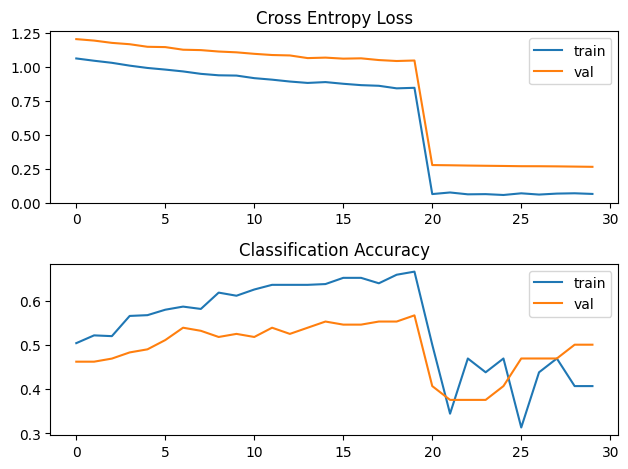

In [20]:
plotTrainingHistory(train_history, val_history)

## Test the model

Evaluate the model in the test set

In [ ]:
# Load the best model
model.load_state_dict(torch.load("recent.pth"))

# Evaluate model on test data
test_loss, test_accuracy = step(model, test_dataloader, loss_fn, device, is_train=False)
print(f"Test loss: {test_loss:.4f}, test accuracy: {test_accuracy:.4f}")

# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

all_labels = []
all_predictions = []

for images, labels in tqdm(test_dataloader):
    images = images.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(images)

    all_labels.extend(labels.cpu().numpy())
    all_predictions.extend(outputs.argmax(dim=1).cpu().numpy())

cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[1, 2, 3, 4], yticklabels=[1, 2, 3, 4])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


## Challenge

In transfer learning, we often replace the head of the model (fully-connected layers responsible for classification) to fit the task. However, these new layers are not pre-trained and thus they contain an error that is backpropagated through the pre-trained part of the network during training. We can avoid this through a training strategy that is divided into two steps:
* Freeze the pre-trained layers of the network so that their parameters are no longer updated during training and train only the head of the model
* Unfreeze these layers and train the network as a whole.

Implement this strategy and see the results!